# aiReview

An OCR reviewer generator, powered by Keras and TensorFlow using convolutional neural networks.


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import cv2
import matplotlib.pyplot as plt
import polars as pl

print("GPUs: ", len(tf.config.list_physical_devices("GPU")))

GPUs:  1


## Load the datasets


Load the digits dataset.


In [2]:
(X_digits_train, y_digits_train), (
    X_digits_val,
    y_digits_val,
) = keras.datasets.mnist.load_data()
X_digits_train = X_digits_train / 255
X_digits_val = X_digits_val / 255

print("Training instances: ", X_digits_train.shape)
print("Validation instances: ", X_digits_val.shape)
print("Training class distribution: ", np.bincount(y_digits_train))
print("Validation class distribution: ", np.bincount(y_digits_val))

Training instances:  (60000, 28, 28)
Validation instances:  (10000, 28, 28)
Training class distribution:  [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Validation class distribution:  [ 980 1135 1032 1010  982  892  958 1028  974 1009]


Load the letters dataset. Note: classes A-Z are mapped to integers 10-35.


In [3]:
letters = pl.read_csv("training/A_Z Handwritten Data.csv", has_header=False).to_numpy()
X_letters = letters[:, 1:]
y_letters = letters[:, 0] + 10
print("Instances: ", X_letters.shape)
print("Class distribution: ", np.bincount(y_letters))

Instances:  (372451, 784)
Class distribution:  [    0     0     0     0     0     0     0     0     0     0 13870  8668
 23409 10134 11440  1163  5762  7218  1120  8493  5603 11586 12336 19010
 57825 19341  5812 11566 48419 22495 29008  4182 10784  6272 10859  6076]


Split the letters dataset to training and validation set.


In [4]:
from sklearn.model_selection import train_test_split

X_letters_train, X_letters_val, y_letters_train, y_letters_val = train_test_split(
    X_letters, y_letters, test_size=0.2, random_state=42, stratify=y_letters
)
X_letters_train = X_letters_train.reshape((-1, 28, 28)) / 255
X_letters_val = X_letters_val.reshape((-1, 28, 28)) / 255

print("Training instances: ", X_letters_train.shape)
print("Validation instances: ", X_letters_val.shape)
print("Training class distribution: ", np.bincount(y_letters_train))
print("Validation class distribution: ", np.bincount(y_letters_val))

Training instances:  (297960, 28, 28)
Validation instances:  (74491, 28, 28)
Training class distribution:  [    0     0     0     0     0     0     0     0     0     0 11096  6934
 18727  8107  9152   930  4610  5774   896  6794  4482  9269  9869 15208
 46260 15473  4650  9253 38735 17996 23206  3346  8627  5018  8687  4861]
Validation class distribution:  [    0     0     0     0     0     0     0     0     0     0  2774  1734
  4682  2027  2288   233  1152  1444   224  1699  1121  2317  2467  3802
 11565  3868  1162  2313  9684  4499  5802   836  2157  1254  2172  1215]


Combine the two datasets.


In [5]:
from sklearn.utils import shuffle

X_train = np.concatenate((X_digits_train, X_letters_train))
y_train = np.concatenate((y_digits_train, y_letters_train))
X_train, y_train = shuffle(X_train, y_train, random_state=42)

X_val = np.concatenate((X_digits_val, X_letters_val))
y_val = np.concatenate((y_digits_val, y_letters_val))
X_val, y_val = shuffle(X_val, y_val, random_state=42)


print("Training instances: ", X_train.shape)
print("Validation instances: ", X_val.shape)
print("Training class distribution: ", np.bincount(y_train))
print("Validation class distribution: ", np.bincount(y_val))

Training instances:  (357960, 28, 28)
Validation instances:  (84491, 28, 28)
Training class distribution:  [ 5923  6742  5958  6131  5842  5421  5918  6265  5851  5949 11096  6934
 18727  8107  9152   930  4610  5774   896  6794  4482  9269  9869 15208
 46260 15473  4650  9253 38735 17996 23206  3346  8627  5018  8687  4861]
Validation class distribution:  [  980  1135  1032  1010   982   892   958  1028   974  1009  2774  1734
  4682  2027  2288   233  1152  1444   224  1699  1121  2317  2467  3802
 11565  3868  1162  2313  9684  4499  5802   836  2157  1254  2172  1215]


Display samples


Classes (36): 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


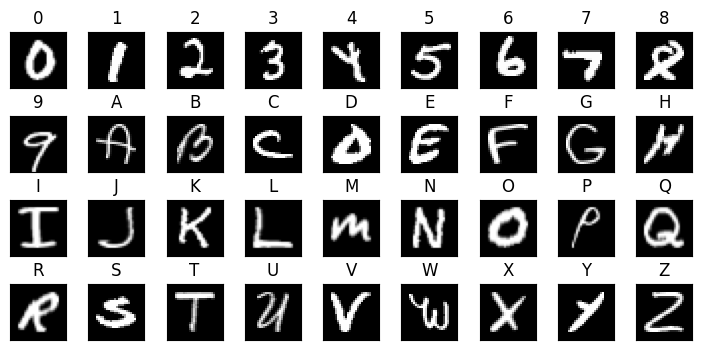

In [6]:
class_names = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
print(f"Classes ({len(class_names)}): {class_names}")
n_rows = 4
n_cols = 9

plt.figure(figsize=(n_cols, n_rows))
for row in range(n_rows):
    for col in range(n_cols):
        label = n_cols * row + col
        index = np.argmax(y_train == label)
        plt.subplot(n_rows, n_cols, label + 1)
        plt.imshow(X_train[index], cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.1, hspace=0.5)

plt.show()

## Training


In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from functools import partial

X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

ConvLayer = partial(
    Conv2D,
    activation="selu",
    kernel_initializer="lecun_uniform",
    padding="SAME",
)
DenseLayer = partial(
    Dense,
    activation="selu",
    kernel_initializer="lecun_uniform",
)

model = Sequential(
    [
        ConvLayer(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
        MaxPooling2D(pool_size=2),
        ConvLayer(filters=128, kernel_size=3),
        ConvLayer(filters=128, kernel_size=3),
        MaxPooling2D(pool_size=2),
        ConvLayer(filters=256, kernel_size=3),
        ConvLayer(filters=256, kernel_size=3),
        MaxPooling2D(pool_size=2),
        Flatten(),
        DenseLayer(units=128),
        Dropout(0.5),
        DenseLayer(units=64),
        Dropout(0.5),
        Dense(
            units=len(class_names),
            activation="softmax",
            kernel_initializer="glorot_uniform",
        ),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

In [8]:
try:
    model = keras.models.load_model("aireview.h5")
except:
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
    )
    history = model.fit(
        X_train, y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val)
    )
    model.save("aireview.h5")

## Testing


### Preprocessing


Read test samples.


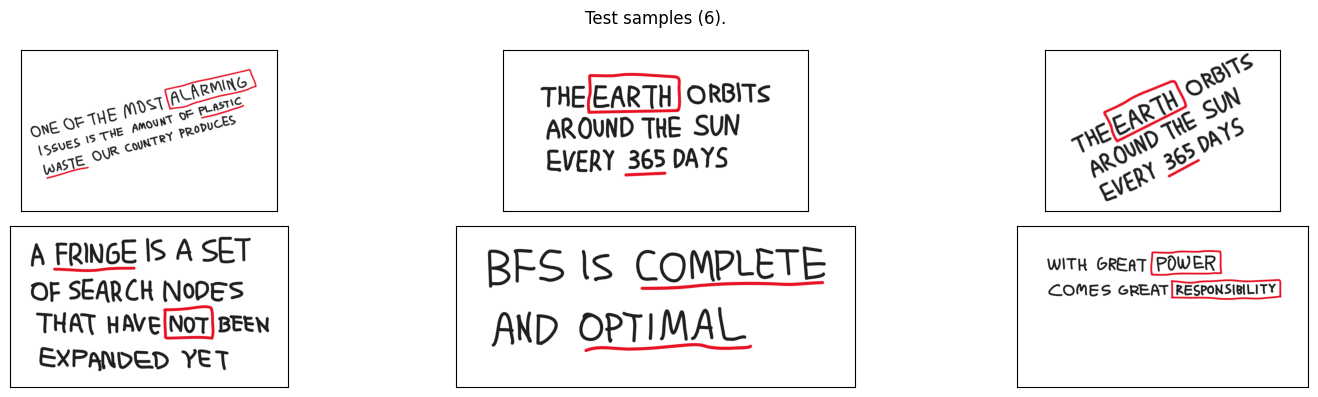

In [9]:
class TestSample:
    def __init__(self, path):
        self.path = path
        self.img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

        # uninitialized attributes:
        self.text_img = None
        self.anno_img = None


test_paths = [rf"testing/test_sample_{i}.png" for i in range(6)]

test_samples = [TestSample(path) for path in test_paths]

fig = plt.figure(figsize=(16, 4))
for idx, sample in enumerate(test_samples):
    plt.subplot(2, 3, idx + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(sample.img)
fig.suptitle(f"Test samples ({len(test_samples)}).")
fig.tight_layout()
plt.show()

Text-Annotation segmentation


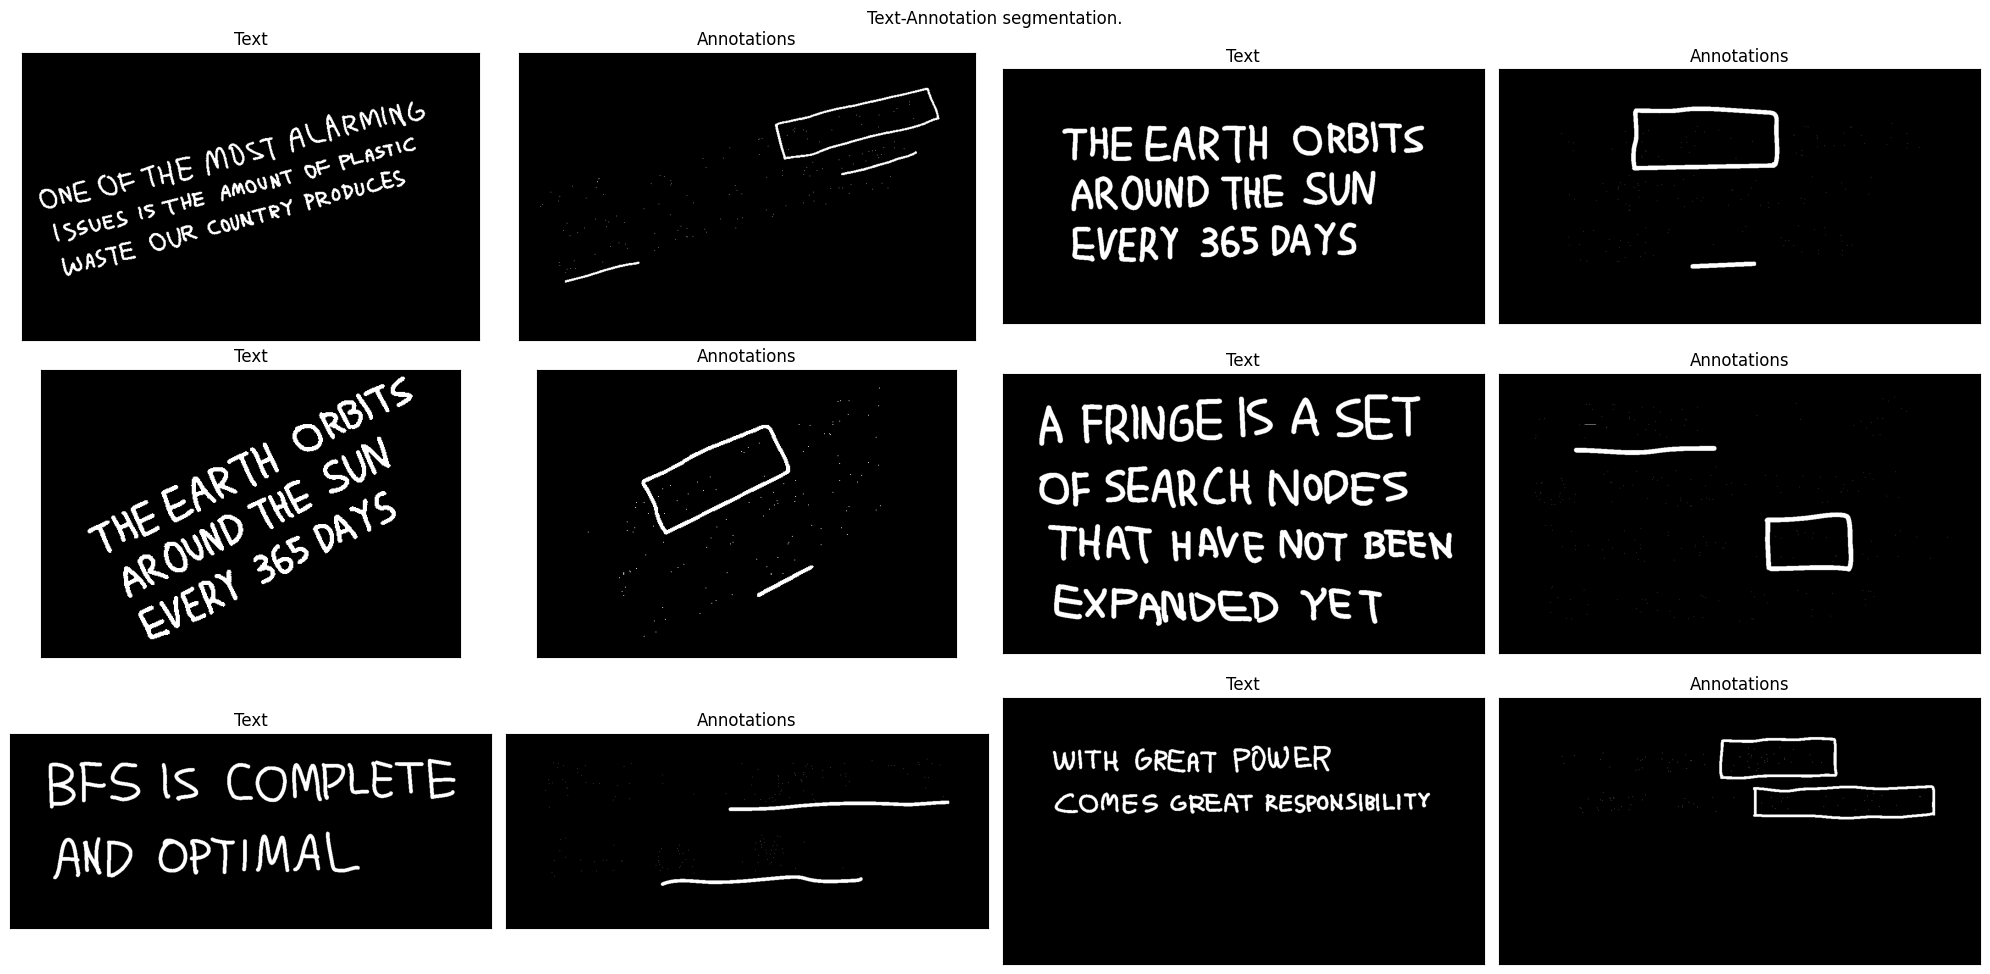

In [10]:
# 179, 44, 130


def get_text(img):
    # filter all black inks
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_text_color = np.array([0, 0, 0])
    upper_text_color = np.array([179, 44, 130])
    text_img = cv2.inRange(img_hsv, lower_text_color, upper_text_color)

    return text_img


def binarize(img):
    img_gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, img_bin = cv2.threshold(img_gs, 127, 255, cv2.THRESH_BINARY_INV)
    return img_bin


def get_annotations(img, text_img):
    img_bin = binarize(img)
    # filter all inks that are not text
    anno_img = cv2.bitwise_xor(img_bin, text_img)
    return anno_img


fig = plt.figure(figsize=(20, 10))
for idx, sample in enumerate(test_samples):
    sample.text_img = get_text(sample.img)
    sample.anno_img = get_annotations(sample.img, sample.text_img)

    plt.subplot(3, 4, 2 * idx + 1)
    plt.imshow(sample.text_img, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Text")

    plt.subplot(3, 4, 2 * idx + 2)
    plt.imshow(sample.anno_img, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("Annotations")
fig.suptitle("Text-Annotation segmentation.")
fig.tight_layout()
plt.show()

Skew correction


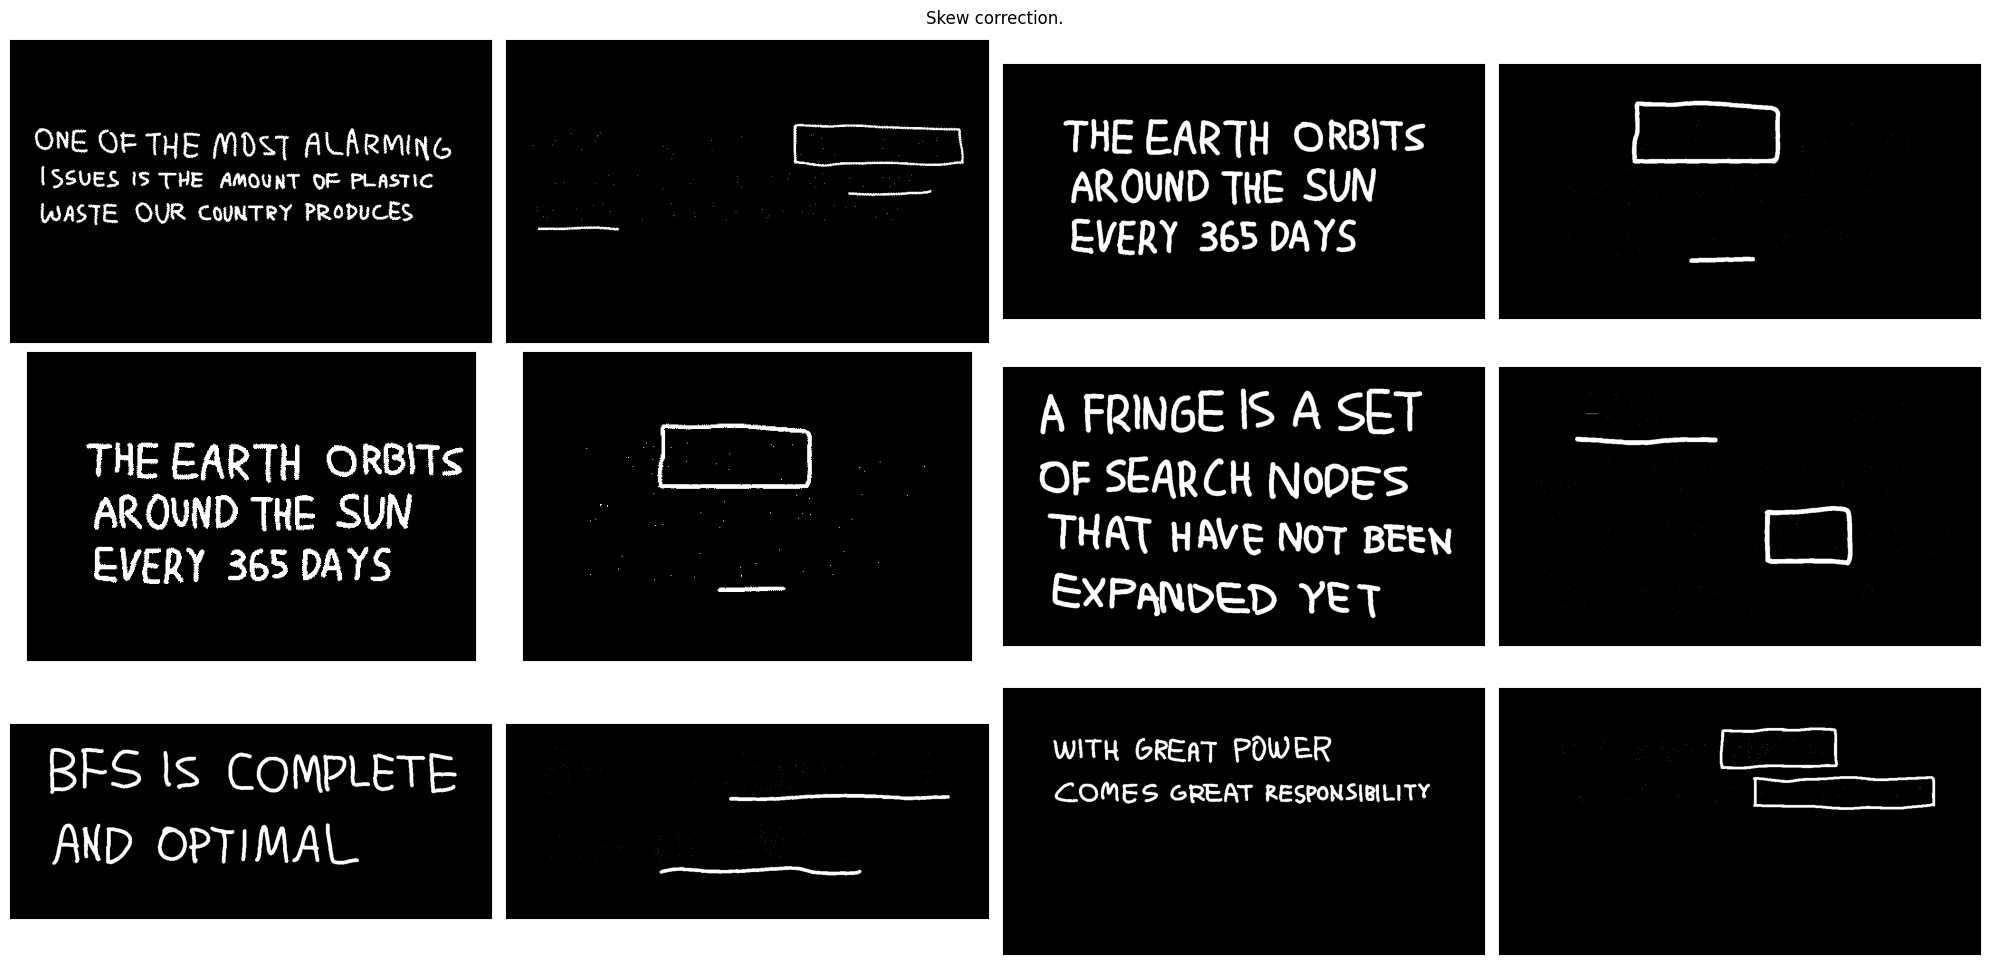

In [11]:

def skew_correct(text_img, anno_img):
    # Reference: https://pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/

    coords = np.column_stack(np.where(text_img > 0))
    angle = cv2.minAreaRect(coords)[-1]

    if angle > 45:
        angle = 90 - angle
    else:
        angle = -angle

    rows, cols = text_img.shape
    rotation = cv2.getRotationMatrix2D(((cols - 1) / 2, (rows - 1) / 2), angle, 1)

    new_text_img = cv2.warpAffine(text_img, rotation, (cols, rows))
    _, new_text_img = cv2.threshold(new_text_img, 127, 255, cv2.THRESH_BINARY)

    new_anno_img = cv2.warpAffine(anno_img, rotation, (cols, rows))
    _, new_anno_img = cv2.threshold(new_anno_img, 127, 255, cv2.THRESH_BINARY)

    return new_text_img, new_anno_img


fig = plt.figure(figsize=(20, 10))
for idx, sample in enumerate(test_samples):
    sample.text_img, sample.anno_img = skew_correct(sample.text_img, sample.anno_img)

    plt.subplot(3, 4, 2 * idx + 1)
    plt.imshow(sample.text_img, cmap="gray")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, 4, 2 * idx + 2)
    plt.imshow(sample.anno_img, cmap="gray")
    plt.xticks([])
    plt.yticks([])

fig.suptitle("Skew correction.")
fig.tight_layout()
plt.show()

Noise removal


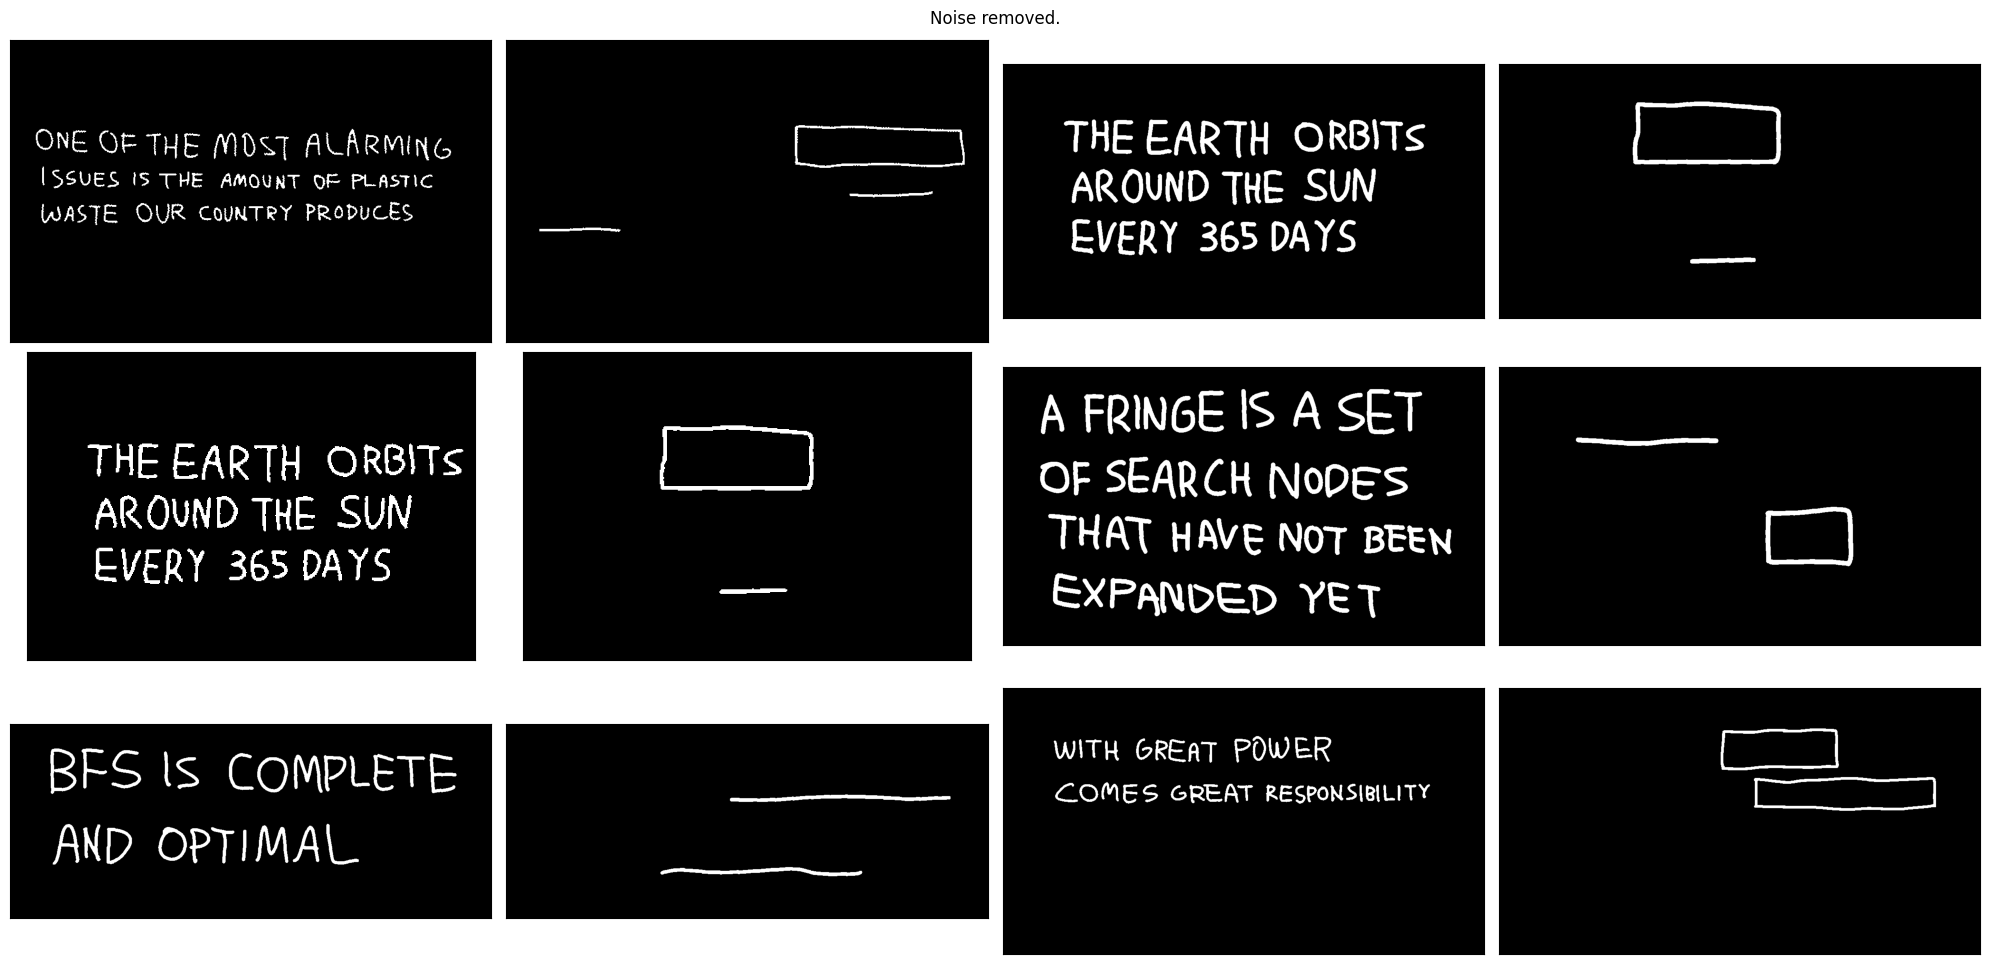

In [12]:
def remove_noise(img):
    kernel_size_open = (2, 2)
    kernel_size_close = (2, 2)

    kernel_open = np.ones(kernel_size_open, np.uint8)
    kernel_close = np.ones(kernel_size_close, np.uint8)

    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_open)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_close)

    img = cv2.fastNlMeansDenoising(img)
    return img


def erode(img):
    kernel_erode_size = (2, 2)
    # kernel_dilate_size = (2, 2)

    kernel_erode = np.ones(kernel_erode_size, np.uint8)
    # kernel_dilate = np.ones(kernel_dilate_size, np.uint8)

    eroded = cv2.erode(img, kernel_erode, iterations=1)
    # eroded = cv2.dilate(eroded, kernel_dilate, iterations=1)

    return eroded


fig = plt.figure(figsize=(20, 10))
for idx, sample in enumerate(test_samples):
    sample.clean_text_img = erode(sample.text_img)
    sample.clean_anno_img = remove_noise(sample.anno_img)

    plt.subplot(3, 4, 2 * idx + 1)
    plt.imshow(sample.clean_text_img, cmap="gray")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3, 4, 2 * idx + 2)
    plt.imshow(sample.clean_anno_img, cmap="gray")
    plt.xticks([])
    plt.yticks([])

fig.suptitle("Noise removed.")
fig.tight_layout()
plt.show()

### Character segmentation


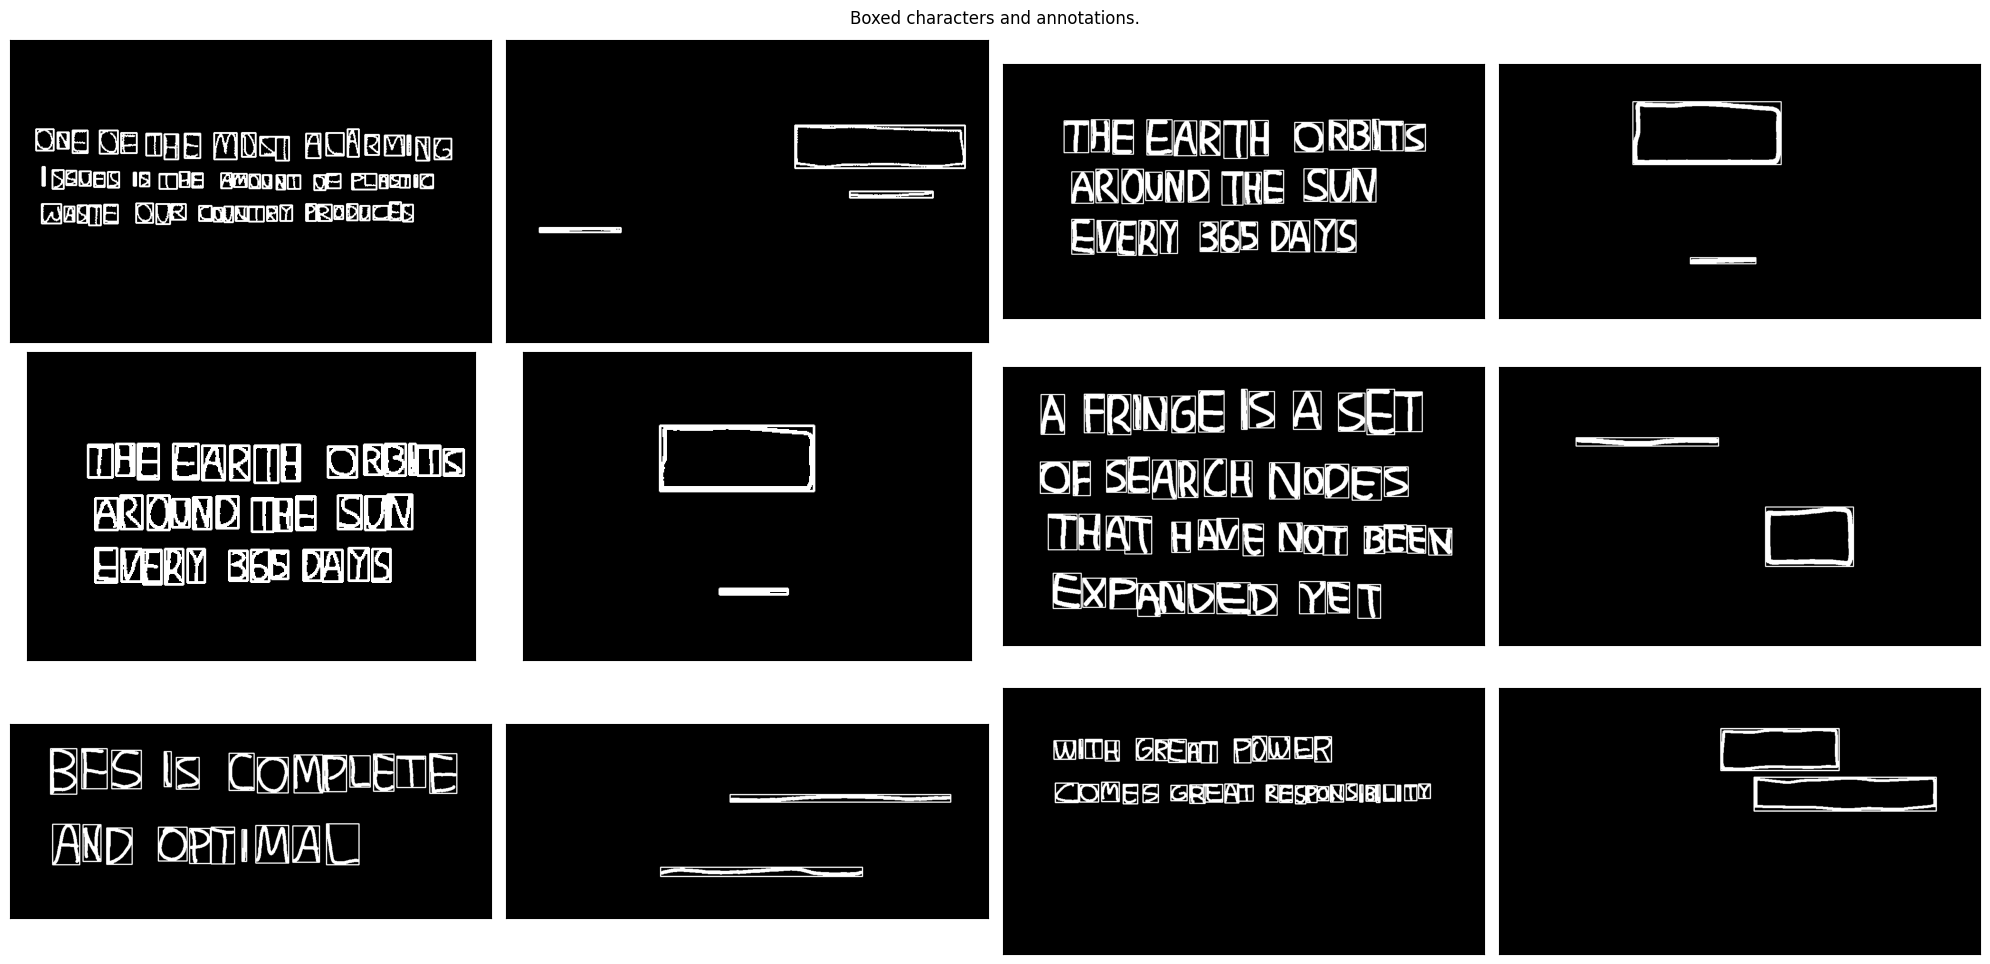

In [13]:

def find_chars(clean_text_img):
    _, components = cv2.connectedComponents(clean_text_img)

    labels = np.unique(components)

    chars = []

    num_chars = 0

    for label in labels:
        if label == 0:
            continue
        else:
            masked = cv2.inRange(components, int(label), int(label))
            char = cv2.boundingRect(masked)  # (x, y, width, height)

            if char[2] > 10 or char[3] > 10:
                num_chars += 1
                # char should be ((x1, y1), (x2, y2))
                char_x1 = char[0]
                char_y1 = char[1]
                char_x2 = char_x1 + char[2]
                char_y2 = char_y1 + char[3]

                chars.append(((char_x1, char_y1), (char_x2, char_y2)))

    return num_chars, chars


def box_chars(clean_text_img, chars):
    boxed_chars = clean_text_img.copy()

    for char in chars:
        boxed_chars = cv2.rectangle(boxed_chars, char[0], char[1], (255, 255, 255), 2)

    return boxed_chars


fig = plt.figure(figsize=(20, 10))
for idx, sample in enumerate(test_samples):
    
    num_chars, chars = find_chars(sample.clean_text_img)
    sample.chars = chars
    boxed_chars = box_chars(sample.clean_text_img, chars)

    plt.subplot(3, 4, 2*idx + 1)
    plt.imshow(boxed_chars, cmap="gray")
    plt.xticks([])
    plt.yticks([])

    num_anno, anno = find_chars(sample.clean_anno_img)
    sample.anno = anno
    boxed_anno = box_chars(sample.clean_anno_img, anno)

    plt.subplot(3, 4, 2*idx + 2)
    plt.imshow(boxed_anno, cmap="gray")
    plt.xticks([])
    plt.yticks([])
fig.suptitle("Boxed characters and annotations.")
fig.tight_layout()

plt.show()

Group the characters into lines / words.


In [14]:
def get_lines(chars):
    chars = sorted(chars, key=lambda pos: pos[0][1])
    lines = [[]]
    for idx in range(len(chars)):
        if idx == 0:
            lines[-1].append(chars[idx])
            continue
        elif chars[idx][0][1] > chars[idx - 1][1][1]: # might need to adjust this...
            lines.append([])
            lines[-1].append(chars[idx])
        else:
            lines[-1].append(chars[idx])

    lines = [list(sorted(line, key=lambda char: char[0][0])) for line in lines]
    return lines


def find_word_space_thresh(lines):
    avg_char_width = sum([sum([char[1][0] - char[0][0] for char in line]) / len(line) for line in lines]) / len(lines)
    return avg_char_width / 1.6


def get_words(lines):
    word_space_thresh = find_word_space_thresh(lines)
    words = []

    for line_idx, line in enumerate(lines):
        words.append([])
        for char_idx, char in enumerate(line):
            if char_idx == 0:
                words[-1].append(char)
                continue
            elif line[char_idx][0][0] - line[char_idx - 1][1][0] > word_space_thresh:
                words.append([])
                words[-1].append(line[char_idx])
            else:
                words[-1].append(line[char_idx])


    return words


for idx, sample in enumerate(test_samples):
    sample.lines = get_lines(sample.chars)
    sample.words = get_words(sample.lines)
    print(f"Sample {idx + 1} - Num of words: ", len(sample.words))


Sample 1 - Num of words:  15
Sample 2 - Num of words:  9
Sample 3 - Num of words:  9
Sample 4 - Num of words:  14
Sample 5 - Num of words:  5
Sample 6 - Num of words:  6


Pad the characters and ensure same aspect ratio

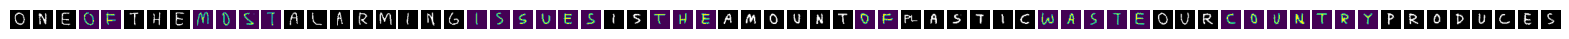

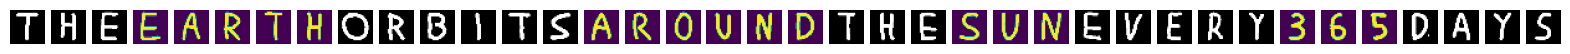

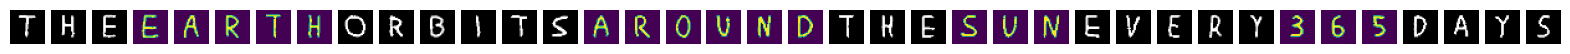

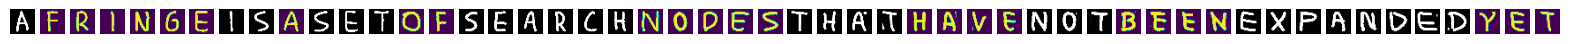

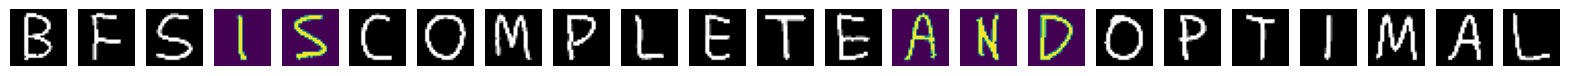

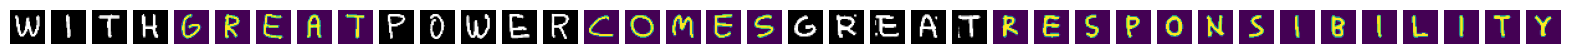

In [15]:

def compute_borders(width, height):
    if height > width:
        border_y = 10
        new_height = 2*border_y + height
        new_width = new_height
        border_x = (new_width - width) // 2
    else:
        border_x = 10
        new_width = 2*border_x + width
        new_height = new_width
        border_y = (new_height - height) // 2
    return border_x, border_y

def pad_chars(clean_text_img, words):
    padded = []
    for word in words:
        padded.append([])
        for char in word:
            sy = char[0][1]
            ey = char[1][1] + 1
            sx = char[0][0]
            ex = char[1][0] + 1
            img = clean_text_img[sy:ey, sx:ex]

            width = ex - sx
            height = ey - sy

            border_x, border_y = compute_borders(width, height)

            img = cv2.copyMakeBorder(img, border_y, border_y, border_x, border_x, cv2.BORDER_CONSTANT, 0)
            img = (cv2.resize(img, (28, 28)) / 255).reshape((28, 28, 1))
            padded[-1].append(img)


    return padded

for idx, sample in enumerate(test_samples):
    plt.figure(figsize=(20, 20))
    sample.padded = pad_chars(sample.clean_text_img, sample.words)
    n_rows = 1
    n_cols = sum([len(word) for word in sample.padded])

    idx = 0
    for word_idx, word in enumerate(sample.padded):
        for char_idx, char in enumerate(word):
            idx += 1
            plt.subplot(n_rows, n_cols, idx)
            plt.axis("off")
            if word_idx % 2 == 0:
                plt.imshow(char, cmap="gray")
            else:
                plt.imshow(char)
    
    plt.show()



Classify annotations

In [16]:
def classify_annotations(anno):
    annotations = {"box": [], "line": []}

    for a in anno:
        height = a[1][1] - a[0][1]
        if height > 50:
            annotations["box"].append(a)
        else:
            annotations["line"].append(a)

    return annotations

for sample in test_samples:
    sample.annotations = classify_annotations(sample.anno)


## Prediction

In [17]:
from IPython.display import display, Markdown

display(Markdown("# Output"))
for idx, sample in enumerate(test_samples):
    output = f"{idx + 1}. "
    bold_mode = False
    for word_idx, word in enumerate(sample.padded):
        for char_idx, char in enumerate(word):
            char_pos = sample.words[word_idx][char_idx]
            char_height = char_pos[1][1] - char_pos[0][1]
            is_lined = False
                
            for anno in sample.annotations["line"]:
                anno_sy, anno_ey = min(anno[0][1], anno[1][1]), max(anno[0][1], anno[1][1])

                if (anno[0][0] <= (char_pos[0][0] + char_pos[1][0]) / 2 <= anno[1][0]) and \
                    (anno_sy - 1.5*char_height <= (char_pos[0][1] + char_pos[1][1]) / 2 <= anno_ey):
                    output += "_"
                    is_lined = True
                    break

            if is_lined:
                continue

            is_bold = False
            for anno in sample.annotations["box"]:
                if (anno[0][0] <= (char_pos[0][0] + char_pos[1][0]) / 2 <= anno[1][0]) and \
                    (anno[0][1] <= (char_pos[0][1] + char_pos[1][1]) / 2 <= anno[1][1]):
                    is_bold = True
                    break

            pred = np.argmax(model.predict(np.array([char,])), axis=-1)[0]

            if is_bold:
                if not bold_mode:
                    bold_mode = True
                    output += "*"
                output += class_names[pred]

            else:
                if not is_bold and bold_mode:
                    bold_mode = False
                    if output[-1] == " ":
                        output = output[:-1] + "* "
                        output += class_names[pred]
                        continue
                    output += "*"
                output += class_names[pred]
        output += " "

    output = output.rstrip() + ("*." if bold_mode else ".")
    display(Markdown(output))


# Output

1. ONE OF THE MOST *ALARM1MG* 1SSUES 1S THE AMOUNT OF ______ _____ OUR COUNTRY PRODUCES.

2. THE *EARTH* ORB1TS AR0UND TKE SUN EVERY ___ DAY5.

3. THE *EARTH* ORB1TS AROUND THE SUN EUERY ___ DAYS.

4. A ______ 1S A SET OT 5EARCK NODES THHT HAVE *N0T* BEEN EXPANDED YET.

5. BFS 1S ________ AKD _______.

6. W1TH GREAT *POWER* COMES GREAT *RESPONS1O1L1TY*.